In [1]:
!mamba env create --quiet -f environment.yml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK

done
Installing pip dependencies: ...working... done


In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [3]:
model = sbm.EQTransformer(phases='PS')

model.cuda();

#### NOTE: tried to download the ETHZ dataset (27 GB) and it filled the memory completely. 

#### The seisbench cache is kept in home/jovyan/.seisbench, and I cleared it out using rm -rfi .seisbench in the terminal

In [6]:
# How to see what's in the cache:
import os
print("Cache root:", seisbench.cache_root)
print("Contents:", os.listdir(seisbench.cache_root))
print("datasets:", os.listdir(seisbench.cache_root / "datasets"))

Cache root: /home/jovyan/.seisbench
Contents: ['datasets', '.seisbench', 'models', 'config.json']
datasets: ['iquique']


In [7]:
data = sbd.Iquique(sampling_rate=100)

2022-03-08 20:43:49,575 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


In [8]:
train, dev, test = data.train_dev_test()

### There are two pieces to a dataset- a csv file containing metadata, and a hdf5 file containing waveforms. 

#### The metadata can be easily viewed as a table.
#### We see that each row contains the information for one pick on one instrument (3 components), including the event origin information.

In [10]:
data.metadata

,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,path_back_azimuth_deg,station_network_code,station_code,trace_channel,station_location_code,station_latitude_deg,...,trace_sampling_rate_hz,trace_completeness,trace_has_spikes,trace_start_time,trace_P_arrival_sample,trace_S_arrival_sample,trace_name_original,trace_chunk,trace_component_order,split
0,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,161.009411,7K,BOLO,EH*,NaN,-18.3400,...,100.0,1.0,False,2014-05-01T00:52:20.630000Z,2000.0,3564.0,7K.BOLO.,,ZNE,train
1,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,311.334575,CX,PB08,HH*,NaN,-20.1411,...,100.0,1.0,False,2014-05-01T00:52:19.048393Z,2000.0,NaN,CX.PB08.,,ZNE,test
2,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,329.936310,DG,IN17,HH*,NaN,-20.4800,...,100.0,1.0,False,2014-05-01T00:52:20.740000Z,2000.0,3551.0,DG.IN17.,,ZNE,dev
3,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,327.358785,DG,IN06,HH*,NaN,-19.6100,...,100.0,1.0,False,2014-05-01T00:52:09.279762Z,2000.0,2697.0,DG.IN06.,,ZNE,train
4,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,211.759639,DG,IN10,HH*,NaN,-19.2900,...,100.0,1.0,False,2014-05-01T00:52:09.700000Z,2000.0,2761.0,DG.IN10.,,ZNE,dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13395,2014-05-30T07:28:54.290000Z,-19.9427,-70.3741,19.73,211.433440,DG,IN23,HH*,NaN,-18.8700,...,100.0,1.0,False,2014-05-30T07:28:55.540000Z,2000.0,NaN,DG.IN23.,,ZNE,test
13396,2014-05-30T07:28:54.290000Z,-19.9427,-70.3741,19.73,198.209665,DG,IN26,HH*,NaN,-19.0400,...,100.0,1.0,False,2014-05-30T07:28:50.370000Z,2000.0,NaN,DG.IN26.,,ZNE,train
13397,2014-05-30T07:28:54.290000Z,-19.9427,-70.3741,19.73,254.910454,CX,PB11,HH*,NaN,-19.7610,...,100.0,1.0,False,2014-05-30T07:28:46.050000Z,2000.0,2938.0,CX.PB11.,,ZNE,test
13398,2014-05-30T07:28:54.290000Z,-19.9427,-70.3741,19.73,181.875522,CX,PB12,HH*,NaN,-18.6141,...,100.0,1.0,False,2014-05-30T07:28:56.100000Z,2000.0,NaN,CX.PB12.,,ZNE,train


#### Let's check out the waveforms in more detail--

In [11]:
import h5py

filename = "/home/jovyan/.seisbench/datasets/iquique/waveforms.hdf5"


f = h5py.File(filename, 'r')

list(f.keys())


['data', 'data_format']

In [12]:
# Looks like they divided up the waveforms based on length?

dset = f['data']
for name in dset:
    print(dset[name])

<HDF5 dataset "bucket0": shape (1024, 3, 16478), type "<f8">
<HDF5 dataset "bucket1": shape (1024, 3, 16483), type "<f8">
<HDF5 dataset "bucket10": shape (1024, 3, 16476), type "<f8">
<HDF5 dataset "bucket11": shape (1024, 3, 18414), type "<f8">
<HDF5 dataset "bucket12": shape (1024, 3, 16465), type "<f8">
<HDF5 dataset "bucket13": shape (69, 3, 16195), type "<f8">
<HDF5 dataset "bucket14": shape (19, 3, 17630), type "<f8">
<HDF5 dataset "bucket2": shape (1024, 3, 16483), type "<f8">
<HDF5 dataset "bucket3": shape (1024, 3, 16474), type "<f8">
<HDF5 dataset "bucket4": shape (1024, 3, 16482), type "<f8">
<HDF5 dataset "bucket5": shape (1024, 3, 16483), type "<f8">
<HDF5 dataset "bucket6": shape (1024, 3, 16477), type "<f8">
<HDF5 dataset "bucket7": shape (1024, 3, 16484), type "<f8">
<HDF5 dataset "bucket8": shape (1024, 3, 16481), type "<f8">
<HDF5 dataset "bucket9": shape (1024, 3, 16474), type "<f8">


In [13]:
dset = f['data_format']
for name in dset:
    print(dset[name])

<HDF5 dataset "component_order": shape (), type "|O">
<HDF5 dataset "dimension_order": shape (), type "|O">
<HDF5 dataset "instrument_response": shape (), type "|O">
<HDF5 dataset "measurement": shape (), type "|O">
<HDF5 dataset "unit": shape (), type "|O">


### Let's look at one of the waveforms:

#### We see that the stored waveform is very long. For the Iquique dataset, it looks like they started the waveform 2000 samples before the P pick, and ended it 12000 samples after the S arrival. 
#### For a 100 Hz sampling rate, this is 2 minutes before P and 12 minutes after S. 
#### Note that not all windows have an S pick- for these traces, it looks like they cut the trace to 12 minutes after the P. 

waveforms.shape: (3, 14001)


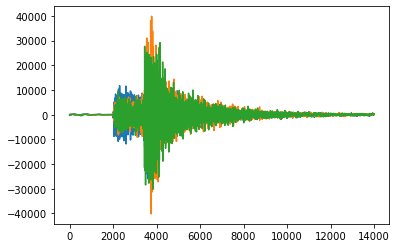

In [14]:
waveforms = data.get_waveforms(1)
print("waveforms.shape:", waveforms.shape)
plt.plot(waveforms.T);

#### In training, the whole window is not used. But, it is useful to store such a long window such that you can vary the start of the training window relative to the pick, such that the phase picker doesn't just learn that P-pick = 2000th sample, for example.

### Now let's start to set up the dataset to work with pytorch.

In [9]:
# Map columns of metadata to relevant pick types:

phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

#### Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
2. Selection of a random window with 3001 samples, the input length of PhaseNet.
3. A normalization, consisting of demeaning and amplitude normalization.
4. A change of datatype to float32, as this is expected by the pytorch model.
5. A probabilistic label

In [65]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=6000, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0),
    # sbg.DetectionLabeller(p_phases="trace_P_arrival_sample",s_phases="trace_S_arrival_sample")
]



train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)


In [40]:
# Does this create more waveforms than we started with? Are there options here to increase the dataset?

# What EXACTLY does sigma mean?

### We can check out some of these samples as follows-

#### Here, we see that the probabilistic labels we added are Gaussian, with standard deviations of 30 samples as defined above. We see that the P and S waves arrive at different times for different examples. We also see that all of the waveform amplitudes have been normalized from -1 to 1, and all waveform lengths are now 3001 samples. 

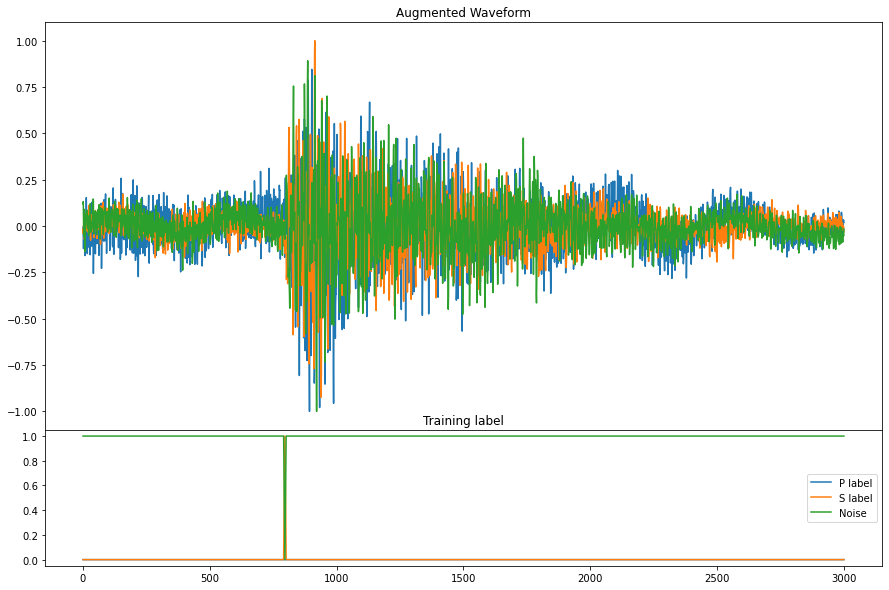

In [41]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[0].set_title('Augmented Waveform')
axs[1].plot(sample["y"].T)
axs[1].set_title('Training label')
axs[1].legend(['P label','S label','Noise'])

In [66]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [67]:
learning_rate = 1e-2
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=0.001):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps) # Same shape as both inputs
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [59]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

#### Note: the below didn't work with EQTransformer, only Phasenet with the phases = "PSN" specified. I assume this has to do with the labelling and I will have to check in on that.

PhaseNet size: torch.Size([256, 3, 3001])

In [77]:
%%time

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 0.704140  [    0/ 8040]


KeyboardInterrupt: 

### We can check out how this worked below by applying the trained model to one of the waveforms in the "development" dataset--



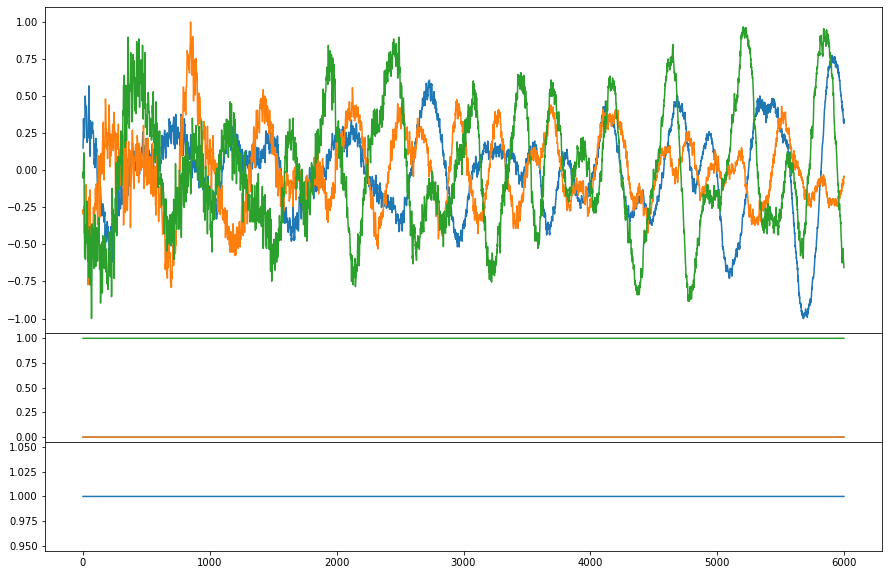

In [78]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

### Alternatively, we can apply it to an obspy waveform using the familiar model.annotate(stream):

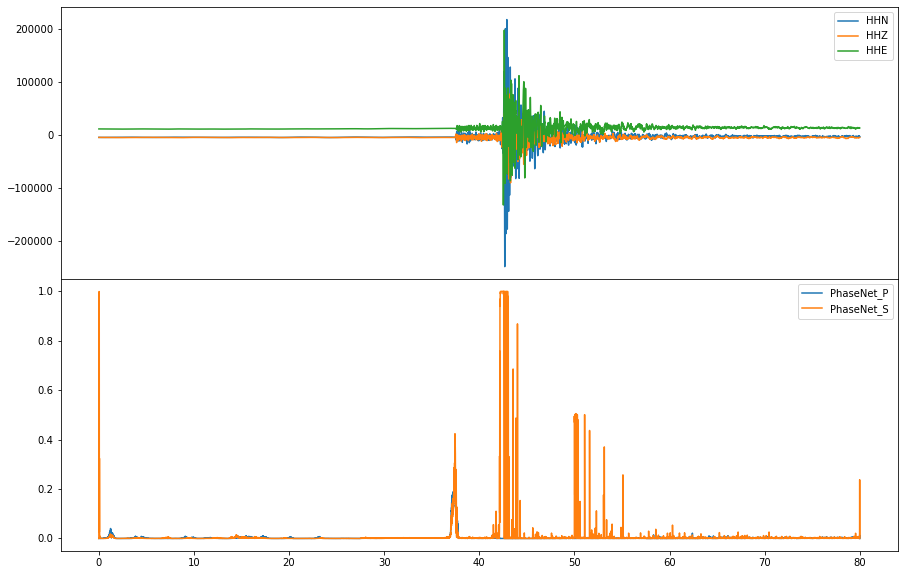

In [13]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [ ]:
# How do you save a trained model?